In [1]:
from readers import *
from datalib import *
from filters import *
import config.config_jump_detection as config
import matplotlib.pyplot as plt
import time as t
%matplotlib notebook

script_starting_time = t.time()

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
expected_jumps = 3
expected_impacts = 2
window_lengths = range(3,41)
best_scores_amount = 5

In [3]:
start_time = t.time()
print("Reading demonstration data")

force_ext = []
position_data = []
velocity_data = []
predictions_data = []
bounds_data = []
jump_indices_data = []
impact_indices_data = []

starting_indices= []
ending_indices = []

for i in range(len(config.demos)):
    demo = config.demos[i]
    print(f'Reading demonstration file {demo}')
    
    predictions_data.append(DataSet())
    bounds_data.append(DataSet())
    jump_indices_data.append([])
    impact_indices_data.append([])

    force_ext.append(DataSet())
    position_data.append(PositionDataSet())
    velocity_data.append(PositionDataSet())

    # Read data
    franka_reader = FrankaStateReader(demo)
    starting_position = None
    ending_position = franka_reader.last_datapoint().value.position
    starting_index = None
    ending_index = None
    
    while not franka_reader.end():
        dp = franka_reader.next_datapoint()
        time = dp.time
        franka_state = dp.value
        
        if starting_position is None:
            starting_position = franka_state.position
        elif starting_index is None:
            if franka_state.distance(starting_position) > 0.01:
                starting_index = len(force_ext[i])
        elif ending_index is None:
            if franka_state.distance(ending_position) < 0.01 and np.linalg.norm(franka_state.velocity) < 0.01:
                ending_index = len(force_ext[i]) + 1

        force_ext[i].append(DataPoint(time, franka_state.force_external_magnitude))
        position_data[i].append(PositionDataPoint(time, franka_state.position))
        velocity_data[i].append(PositionDataPoint(time, franka_state.velocity))

    if ending_index is None:
        ending_index = -1
    
    starting_indices.append(starting_index)
    ending_indices.append(ending_index)
        
    # Align time
    force_ext[i].align_time()
    position_data[i].align_time()
    velocity_data[i].align_time()

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Reading demonstration data
Reading demonstration file data/demo1.bag
Reading demonstration file data/demo2.bag
Reading demonstration file data/demo3.bag
Reading demonstration file data/demo4.bag
Reading demonstration file data/demo5.bag
Reading demonstration file data/demo8.bag
Reading demonstration file data/demo10.bag
Reading demonstration file data/demo11.bag
Reading demonstration file data/demo12.bag
Reading demonstration file data/demo13.bag
Reading demonstration file data/demo14.bag
Reading demonstration file data/demo15.bag
Reading demonstration file data/demo18.bag
Reading demonstration file data/demo19.bag
Reading demonstration file data/demo21.bag
--- 72.11564302444458 seconds ---
Done


In [4]:
def calc_proposed_bound(demo_local_maxima, expected_jumps_=None):
    if expected_jumps_ is None:
        expected_jumps_ = expected_jumps
    local_maxima_copy = demo_local_maxima.copy()
    local_maxima_copy.sort(reverse=True)
    return local_maxima_copy[expected_jumps_]

def propose_bound(proposed_bounds):
    return max(proposed_bounds)

def calc_score(detected_jumps, expected_jumps_=None):
    if expected_jumps_ is None:
        expected_jumps_ = expected_jumps
    return (expected_jumps_ - detected_jumps)**2

In [5]:
start_time = t.time()
print("Analyzing different window lengths")

scores1 = []
proposed_bounds1 = []

for window_length in window_lengths:

    jump_detector = config.jump_detector.copy()
    jump_detector.max_window_length = window_length
    jump_detector.bounder = NoneBounder()

    # Initialize results
    predictions = []
    all_local_maxima = []
    proposed_bounds = []

    for i in range(len(config.demos)):

        predictions.append(DataSet())

#         print(f'Detecting jumps of demonstration file {config.demos[i]}')

        # Detect jumps
        jump_detector.reset()
        for j in range(len(force_ext[i])):
            jump_detected, info = jump_detector.update(force_ext[i][j])
            predictions[i].append(info[0])

        # Output the data
        pred_diff = (force_ext[i] - predictions[i]).value
        local_maxima = []
        for j in range(len(pred_diff) - 2):
            k = j + 1
            if pred_diff[k] is None:
                continue
            if (pred_diff[k-1] is None or pred_diff[k] > pred_diff[k-1]) and (pred_diff[k+1] is None or pred_diff[k] > pred_diff[k+1]):
                local_maxima.append(pred_diff[k])
        all_local_maxima.append(local_maxima)
        proposed_bounds.append(calc_proposed_bound(local_maxima, expected_impacts+1))

    # Calculate score
    score = 0
    proposed_bound = propose_bound(proposed_bounds)
    jump_detector.bounder = config.jump_detector.bounder.copy()
    jump_detector.bounder.set_bound(proposed_bound)
    for i in range(len(config.demos)):

        detected_jumps = 0

        # Detect jumps
        jump_detector.reset()
        for j in range(len(force_ext[i])):
            jump_detected, info = jump_detector.update(force_ext[i][j])
            if info[5]:
                detected_jumps += 1
        score += calc_score(detected_jumps)

    scores1.append(score)
    proposed_bounds1.append(proposed_bound)

    print(f"The proposed bounds per demo for window_length {window_length} are {proposed_bounds} with a proposed_bound of {proposed_bound}")
    print(f"Score for window_length {window_length} is {score}")

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Analyzing different window lengths
The proposed bounds per demo for window_length 3 are [1.6152633037648998, 2.43709382849538, 2.389964536682946, 2.251906400067355, 1.6875264208414187, 1.44670542352155, 1.4322314195406571, 1.2222401219808248, 1.1343623295433005, 1.4603295918310017, 1.9629922799757615, 1.0719905141169637, 1.2636180562787458, 1.2444339049218023, 1.9022852881973087] with a proposed_bound of 2.43709382849538
Score for window_length 3 is 21
The proposed bounds per demo for window_length 4 are [1.7637867289044387, 2.6545364568161816, 2.803083333010999, 2.4892081705004223, 1.8395417343570544, 1.8952561678375268, 1.5091825005799073, 1.5160840197686447, 1.757337424593441, 1.8077625856339168, 2.7021071681572195, 1.5489126599537677, 1.8788912141728211, 1.7069912930249025, 1.77471829330959] with a proposed_bound of 2.803083333010999
Score for window_length 4 is 10
The proposed bounds per demo for window_length 5 are [2.4572124876583015, 2.768275365179825, 3.070112406089521, 3.0908

The proposed bounds per demo for window_length 23 are [2.758331294831123, 4.880776495452411, 9.144740267174996, 4.505889854895633, 4.973956715991401, 2.6032790936448453, 10.076597275932173, 8.685121216629835, 8.983432648064142, 2.277928064253377, 2.31051802212093, 7.262848187696299, 8.003142136881102, 1.7936591655797454, 2.880227199974348] with a proposed_bound of 10.076597275932173
Score for window_length 23 is 8
The proposed bounds per demo for window_length 24 are [2.811584167281108, 5.209092569347048, 9.862803128625359, 4.295502014591824, 4.924123699332425, 2.591060381619087, 2.639920446793358, 9.25136519469136, 9.469403409894657, 2.5117841826639165, 4.6625367582712, 7.770817951938106, 7.7484714583832215, 1.9298503401897449, 2.0188266959892593] with a proposed_bound of 9.862803128625359
Score for window_length 24 is 3
The proposed bounds per demo for window_length 25 are [2.972873997918679, 5.481355588442073, 5.015840416806265, 4.01880872901871, 4.7931992342398235, 2.59424426803797

In [6]:
start_time = t.time()
print("Calculating results")

all_best_indices1 = [i for i, value in sorted(enumerate(scores1), key=lambda x:x[1])]
best_indices1 = all_best_indices1[0:best_scores_amount]
index = best_scores_amount
while index < len(scores1) and scores1[all_best_indices1[index]] == scores1[all_best_indices1[best_scores_amount-1]]:
    best_indices1.append(all_best_indices1[index])
    index += 1
best_scores1 = [scores1[i] for i in best_indices1]
best_window_lengths1 = [window_lengths[i] for i in best_indices1]
best_bounds1 = [proposed_bounds1[i] for i in best_indices1]
print(f'The {len(best_window_lengths1)} proposed window lengths are {best_window_lengths1} with bounds {best_bounds1} with scores {best_scores1}')

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Calculating results
The 5 proposed window lengths are [24, 25, 22, 21, 26] with bounds [9.862803128625359, 9.867738470940107, 9.449891751242266, 9.26692874029263, 10.465419666158581] with scores [3, 3, 4, 5, 6]
--- 0.0005526542663574219 seconds ---
Done


<IPython.core.display.Javascript object>


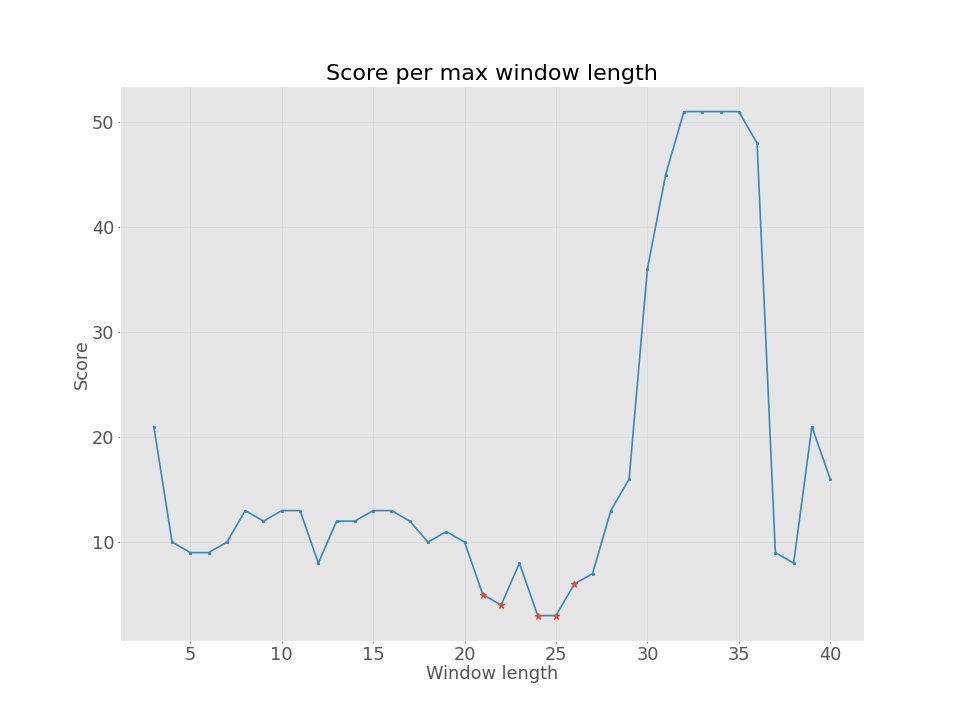

In [7]:
fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
plt.rcParams['xtick.labelsize'] = config.fontsize2
plt.rcParams['ytick.labelsize'] = config.fontsize2
plt.plot(window_lengths, scores1,'C1-*', linewidth=config.linewidth, markersize=config.markersize3, label='Scores')
plt.plot(best_window_lengths1, best_scores1,'C7*', linewidth=config.linewidth, markersize=config.markersize2, label='Best scores')
plt.title('Score per max window length',fontsize=config.fontsize1)
plt.xlabel('Window length',fontsize=config.fontsize2)
plt.ylabel('Score',fontsize=config.fontsize2)
plt.show()

In [8]:
expected_impacts = 2

In [9]:
def calc_proposed_bound(prediction_differences):
    return min(prediction_differences)

def propose_bound(proposed_bounds):
    if len(proposed_bounds) > 0:
        return min(proposed_bounds)
    return None

def calc_score(detected_jumps, expected_jumps_=None):
    if expected_jumps_ is None:
        expected_jumps_ = expected_impacts
    return (expected_jumps_ - detected_jumps)**2

In [10]:
start_time = t.time()
print("Evaluating bounds and window_lengths")

all_scores2 = []
all_proposed_bounds2 = []

for w in range(len(best_window_lengths1)):
    window_length = best_window_lengths1[w]
    bound = best_bounds1[w]
    
    print(f'Analyzing window_length {window_length} with bound {bound}')
    
    jump_indices = []
    predictions = []
    scores = []
    proposed_bounds = []
    
    for i in range(len(config.demos)):
        jump_indices.append([])
        predictions.append(DataSet())
        
        # Detect jumps
        jump_detector = config.jump_detector
        jump_detector.max_window_length = window_length
        jump_detector.bounder.set_bound(bound)
        jump_detector.reset()
        for j in range(len(force_ext[i])):
            jump_detected, info = jump_detector.update(force_ext[i][j])
            predictions[i].append(info[0])
            if jump_detected:
                jump_indices[i].append(j)
        
        # Calculate score
        score = calc_score(len(jump_indices[i]))
        scores.append(score)

        print(f"Score for demonstration file {config.demos[i]} is {score}")

        # Demo is valid
        if score == 0:
            jump_diffs = DataSet([force_ext[i][j] - predictions[i][j] for j in jump_indices[i]])
            proposed_bounds.append(calc_proposed_bound(jump_diffs.value))
    
    proposed_bound = propose_bound(proposed_bounds)
    all_scores2.append(scores)
    all_proposed_bounds2.append(proposed_bound)
    print(f"The proposed bounds are {proposed_bounds} with a proposed value of {proposed_bound}")
    
print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Evaluating bounds and window_lengths
Analyzing window_length 24 with bound 9.862803128625359
Score for demonstration file data/demo1.bag is 0
Score for demonstration file data/demo2.bag is 1
Score for demonstration file data/demo3.bag is 0
Score for demonstration file data/demo4.bag is 0
Score for demonstration file data/demo5.bag is 0
Score for demonstration file data/demo8.bag is 1
Score for demonstration file data/demo10.bag is 0
Score for demonstration file data/demo11.bag is 0
Score for demonstration file data/demo12.bag is 0
Score for demonstration file data/demo13.bag is 0
Score for demonstration file data/demo14.bag is 0
Score for demonstration file data/demo15.bag is 1
Score for demonstration file data/demo18.bag is 0
Score for demonstration file data/demo19.bag is 0
Score for demonstration file data/demo21.bag is 1
The proposed bounds are [11.219368021486275, 10.219085820796934, 10.433048745084765, 10.51013166001788, 9.941463387601697, 10.438173024081358, 9.910265664084811, 1

In [11]:
start_time = t.time()
print("Calculating results")

total_scores2 = []
for scores in all_scores2:
    total_scores2.append(sum(scores))
    
print(f'The total scores for window_lengths {best_window_lengths1} with bounds {best_bounds1} are {total_scores2}')

indices2a = [i for i, value in sorted(enumerate(total_scores2), key=lambda x:x[1])]
best_indices2 = [indices2a[0]]
best_total_score2 = total_scores2[indices2a[0]]
index = 1
while index < len(total_scores2) and total_scores2[indices2a[index]] == best_total_score2:
    best_indices2.append(indices2a[index])
    index += 1

best_scores2 = [total_scores2[i] for i in best_indices2]
best_window_lengths2 = [best_window_lengths1[i] for i in best_indices2]
best_bounds2 = [best_bounds1[i] for i in best_indices2]

indices2b = [i for i, value in sorted(enumerate(best_bounds2), key=lambda x:x[1])]
best_window_length2 = best_window_lengths2[indices2b[0]]
best_score2 = best_scores2[indices2b[0]]
best_bound2 = best_bounds2[indices2b[0]]

print(f'The proposed window length is {best_window_length2} with bound {best_bound2} with score {best_score2}')
indices2c = [i for i,j in enumerate(all_scores2[best_window_lengths1.index(best_window_length2)]) if j > 0]
print(f'The neglected demonstration files are {[config.demos[i] for i in indices2c]}')

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Calculating results
The total scores for window_lengths [24, 25, 22, 21, 26] with bounds [9.862803128625359, 9.867738470940107, 9.449891751242266, 9.26692874029263, 10.465419666158581] are [4, 4, 5, 6, 7]
The proposed window length is 24 with bound 9.862803128625359 with score 4
The neglected demonstration files are ['data/demo2.bag', 'data/demo8.bag', 'data/demo15.bag', 'data/demo21.bag']
--- 0.0008304119110107422 seconds ---
Done


In [12]:
indices_to_plot = np.argsort(best_window_lengths1)

fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
plt.rcParams['xtick.labelsize'] = config.fontsize2
plt.rcParams['ytick.labelsize'] = config.fontsize2
plt.plot([best_window_lengths1[i] for i in indices_to_plot], [total_scores2[i] for i in indices_to_plot],'C1-*', linewidth=config.linewidth, markersize=config.markersize3, label='Scores')
plt.plot(best_window_length2, best_score2,'C7*', linewidth=config.linewidth, markersize=config.markersize2, label='Best score')
plt.title('Best window length scores',fontsize=config.fontsize1)
plt.xlabel('Window length',fontsize=config.fontsize2)
plt.ylabel('Score',fontsize=config.fontsize2)
plt.show()

<IPython.core.display.Javascript object>

In [13]:
start_time = t.time()
print("Detecting jumps")

indices3 = [i for i,j in enumerate(all_scores2[best_window_lengths1.index(best_window_length2)]) if j == 0]
jump_detector = config.jump_detector.copy()
jump_detector.max_window_length = best_window_length2
jump_detector.bounder.set_bound(best_bound2)

for i in indices3:
    
    # Detect jumps
    jump_detector.reset()
    starting_index = starting_indices[i]
    ending_index = ending_indices[i]
    for j in range(len(force_ext[i][starting_index:ending_index])):
        jump_detected, info = jump_detector.update(force_ext[i][j+starting_index])
        if jump_detected:
            impact_indices_data[i].append(j+starting_index)
        if info[5]:
            jump_indices_data[i].append(j+starting_index)
        predictions_data[i].append(info[0])
        bounds_data[i].append(info[1])
        
print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Detecting jumps
--- 4.006497383117676 seconds ---
Done


In [14]:
start_time = t.time()
print("Analyzing result")

mean_errors = []

for i in indices3:
    # Print result
    demo = config.demos[i]
    starting_index = starting_indices[i]
    ending_index = ending_indices[i]
    pred_diff = abs(force_ext[i][starting_index:ending_index] - predictions_data[i])
    mean_error = np.sqrt(np.mean([i**2 for i in pred_diff.value if i is not None]))
    mean_errors.append(mean_error)
    print(f"For demo {demo}, the jump indices are", jump_indices_data[i], "with jump times", force_ext[i][jump_indices_data[i]].time)
    print(f"For demo {demo}, the impact indices are", impact_indices_data[i], "with impact times", force_ext[i][impact_indices_data[i]].time)
    print(f'For demonstration {demo} the mean squared absolute difference between data and prediction is {mean_error}')
    print(f'{max([i for i in pred_diff.value if i is not None])}')
    
print(f'The mean mean error is {np.mean(mean_errors)} and has a minumum value of {min(mean_errors)} and a maximum value of {max(mean_errors)}')

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Analyzing result
For demo data/demo1.bag, the jump indices are [799, 809, 837] with jump times [2.0649688243865967, 2.0899484157562256, 2.161982297897339]
For demo data/demo1.bag, the impact indices are [799, 837] with impact times [2.0649688243865967, 2.161982297897339]
For demonstration data/demo1.bag the mean squared absolute difference between data and prediction is 1.5689446759109762
14.09475900074589
For demo data/demo3.bag, the jump indices are [1218, 1226, 1252] with jump times [3.1049678325653076, 3.125988483428955, 3.1959545612335205]
For demo data/demo3.bag, the impact indices are [1218, 1252] with impact times [3.1049678325653076, 3.1959545612335205]
For demonstration data/demo3.bag the mean squared absolute difference between data and prediction is 1.9445032121664134
11.238017073738494
For demo data/demo4.bag, the jump indices are [947, 955, 971] with jump times [2.438277244567871, 2.460233211517334, 2.5022826194763184]
For demo data/demo4.bag, the impact indices are [947,

In [15]:
# Print demos and impact indices

print('demos = [')
j = 0
for i in indices3:
    print(f'\t{config.demos[i]}',end='')
    if j < len(indices3) - 1:
        print(',')
    else:
        print('')
    j += 1
print(']')

print('')

print('impact_intervals = [')
j = 0
for i in indices3:
    print('\t[(', end='')
    for index in impact_indices_data[i]:
        print(index, end=',')
    if j < len(indices3) - 1:
        print(')],')
    else:
        print(')]')
    j += 1
print(']')

demos = [
	data/demo1.bag,
	data/demo3.bag,
	data/demo4.bag,
	data/demo5.bag,
	data/demo10.bag,
	data/demo11.bag,
	data/demo12.bag,
	data/demo13.bag,
	data/demo14.bag,
	data/demo18.bag,
	data/demo19.bag
]

impact_intervals = [
	[(799,837,)],
	[(1218,1252,)],
	[(947,971,)],
	[(1524,1559,)],
	[(1056,1091,)],
	[(1080,1115,)],
	[(1020,1059,)],
	[(892,926,)],
	[(1145,1180,)],
	[(866,903,)],
	[(928,960,)]
]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


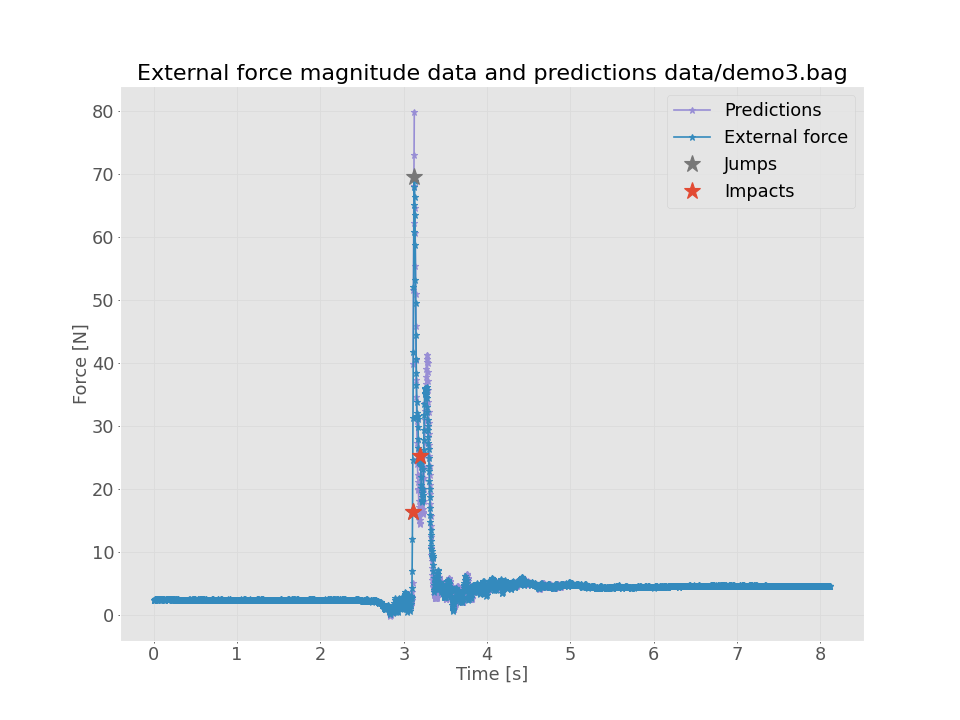

<IPython.core.display.Javascript object>


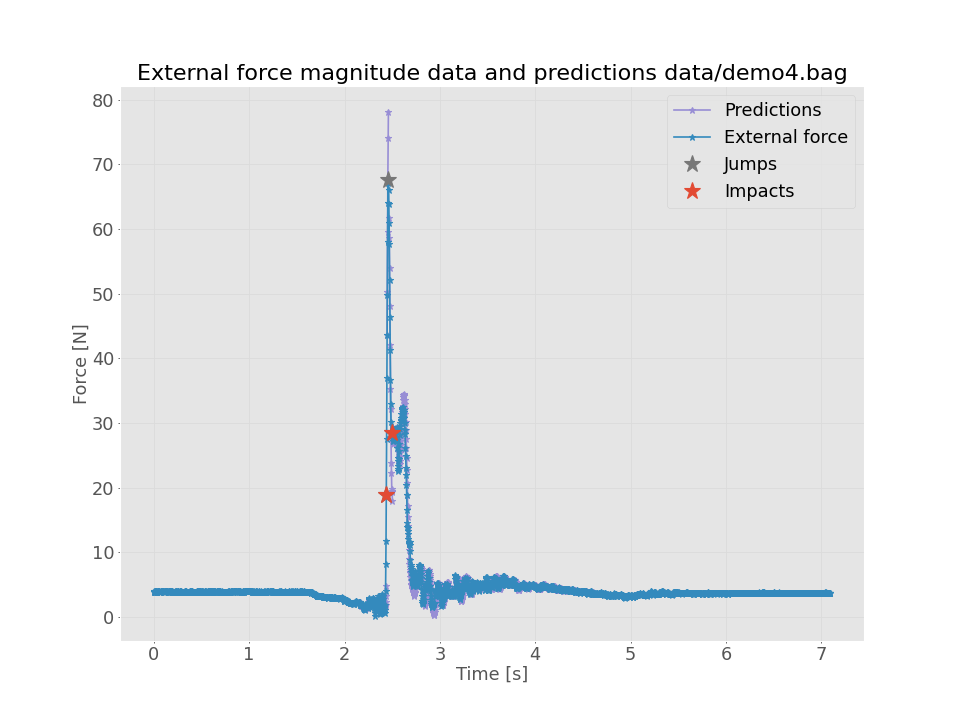

<IPython.core.display.Javascript object>


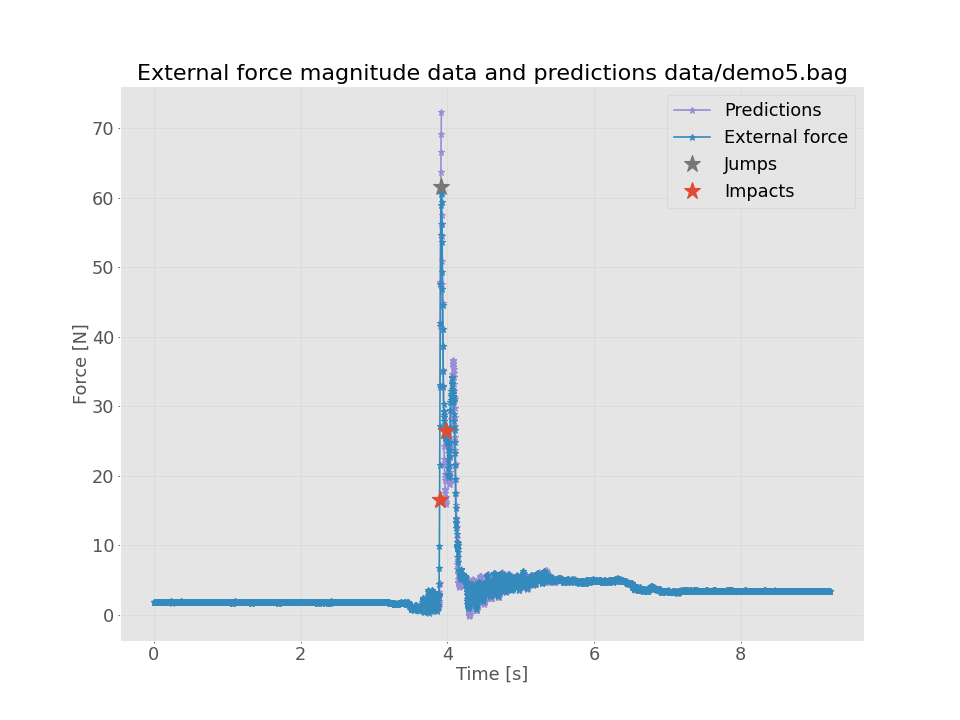

<IPython.core.display.Javascript object>


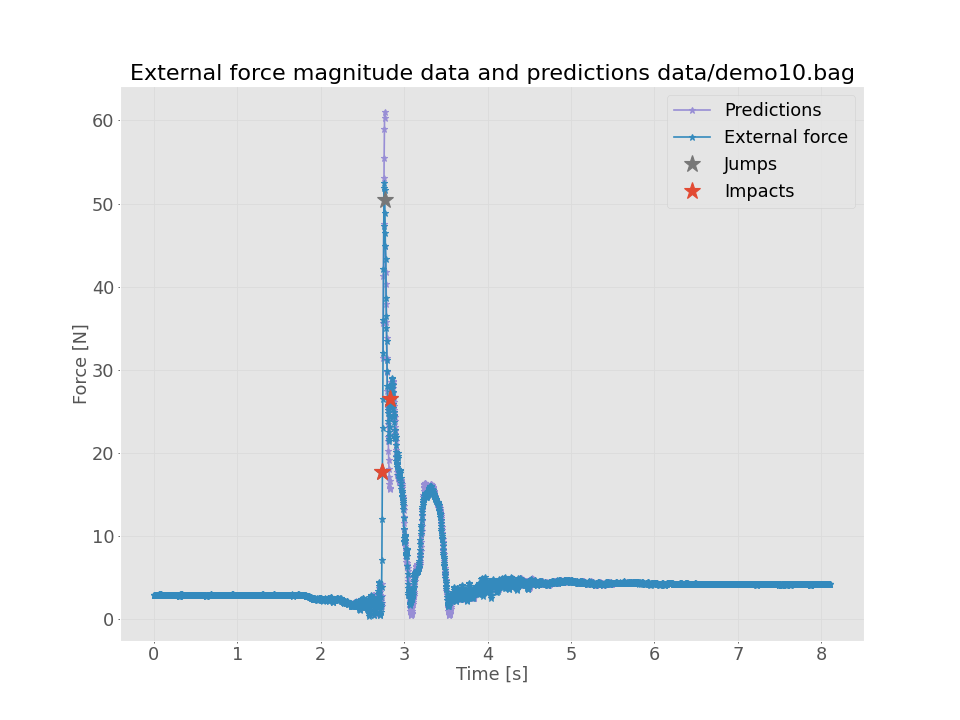

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


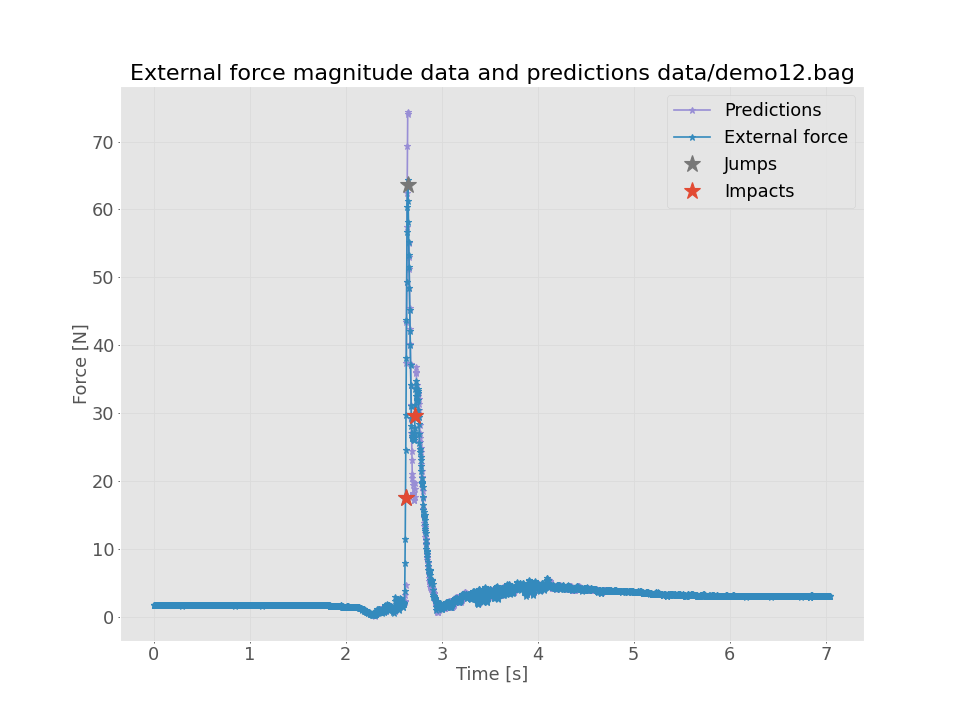

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


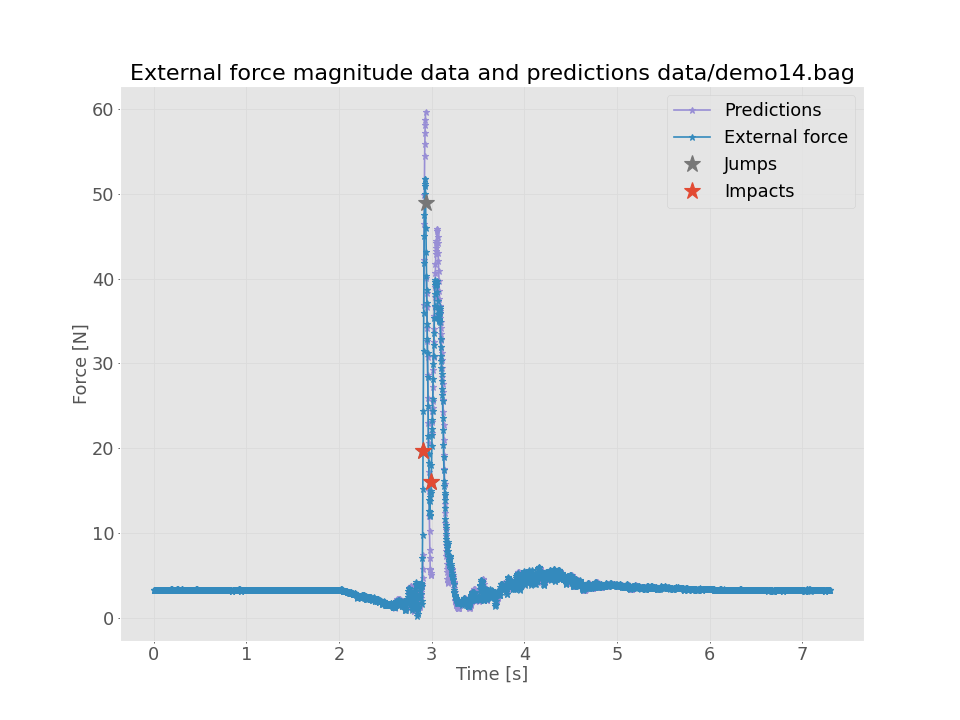

<IPython.core.display.Javascript object>


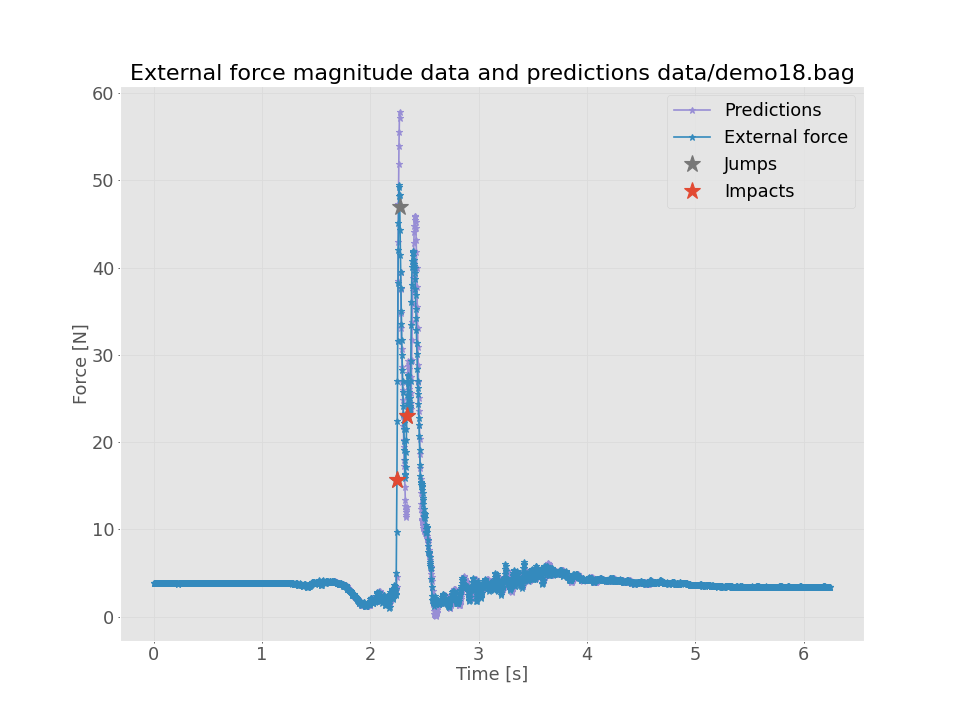

<IPython.core.display.Javascript object>


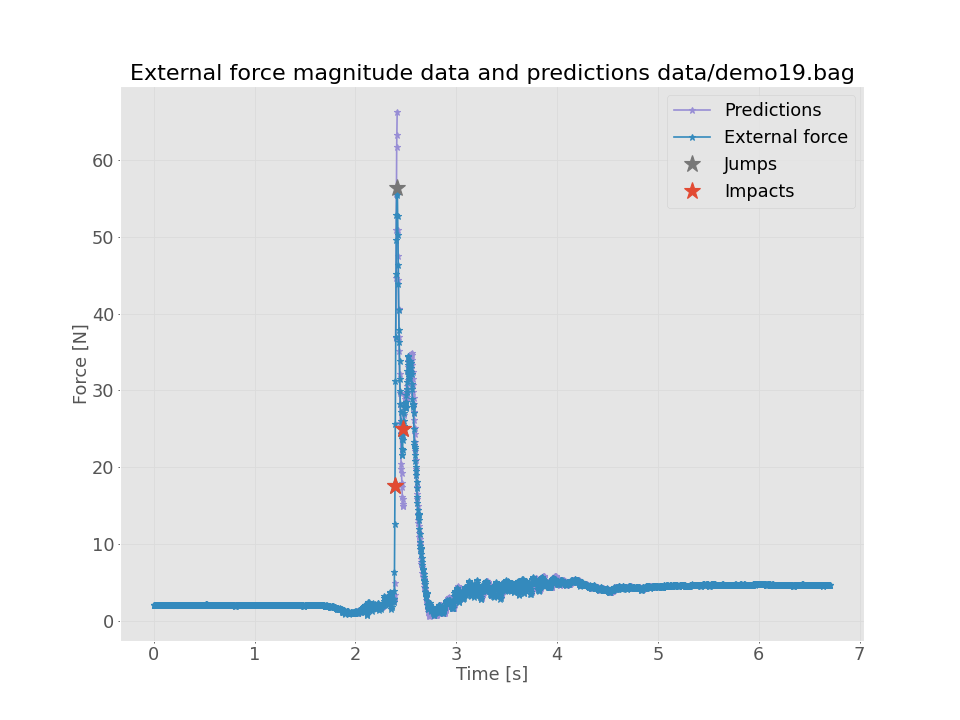

In [16]:
# Plotting external force data

for i in indices3:
    demo = config.demos[i]
    
    ## Plot external force
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Predictions
    plt.plot(predictions_data[i].time, predictions_data[i].value, 'C2-*', linewidth=config.linewidth, markersize=config.markersize2, label='Predictions')

    # External force data
    plt.plot(force_ext[i].time, force_ext[i].value, 'C1-*', linewidth=config.linewidth, markersize=config.markersize2, label='External force')

    # Jumps and impacts
    force_ext_jumps = force_ext[i][jump_indices_data[i]]
    plt.plot(force_ext_jumps.time, force_ext_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Jumps')
    force_ext_impacts = force_ext[i][impact_indices_data[i]]
    plt.plot(force_ext_impacts.time, force_ext_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Impacts')
    
    # Adding title and labels
    plt.title('External force magnitude data and predictions ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Force [N]',fontsize=config.fontsize2)
    plt.legend(fontsize=config.fontsize2)
    if config.xlim is not None and config.xlim[i] is not None:
        plt.xlim(config.xlim[i])

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()

if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


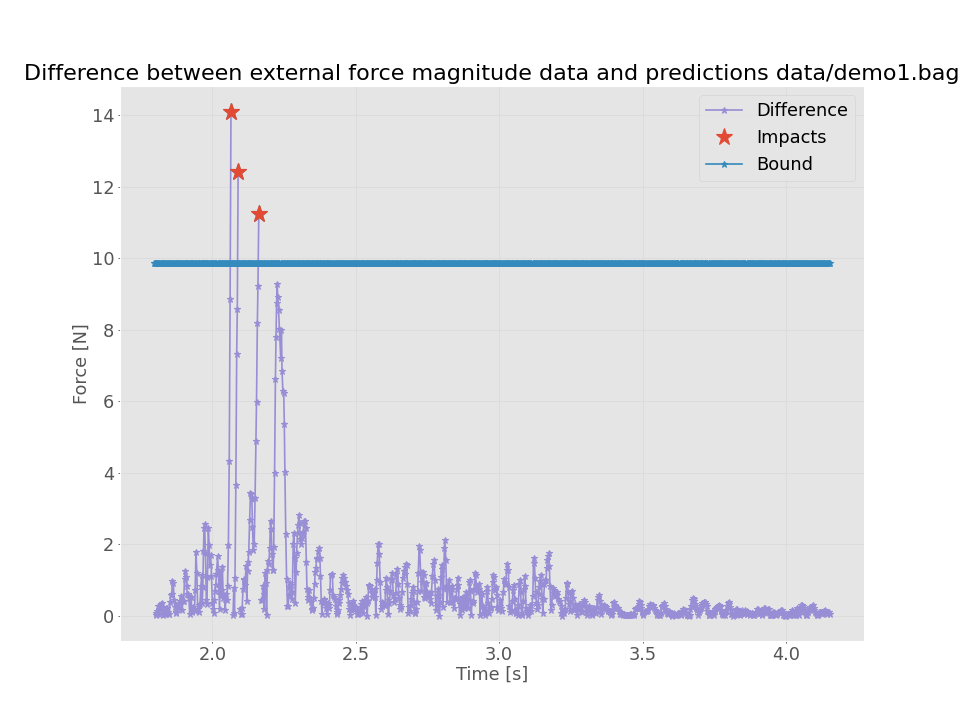

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


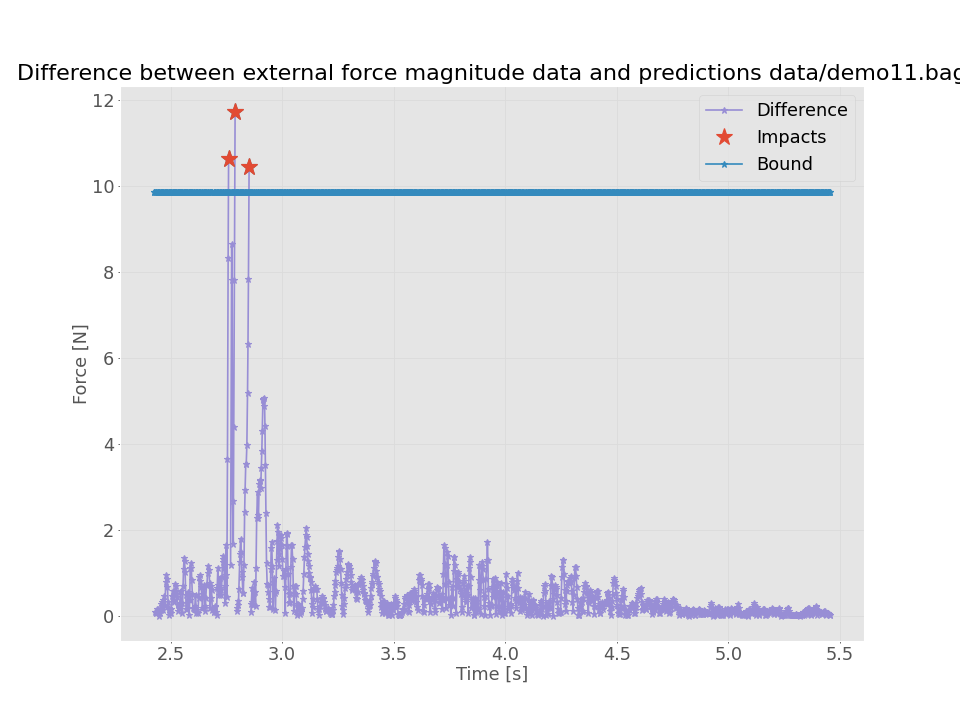

<IPython.core.display.Javascript object>

/home/sven/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


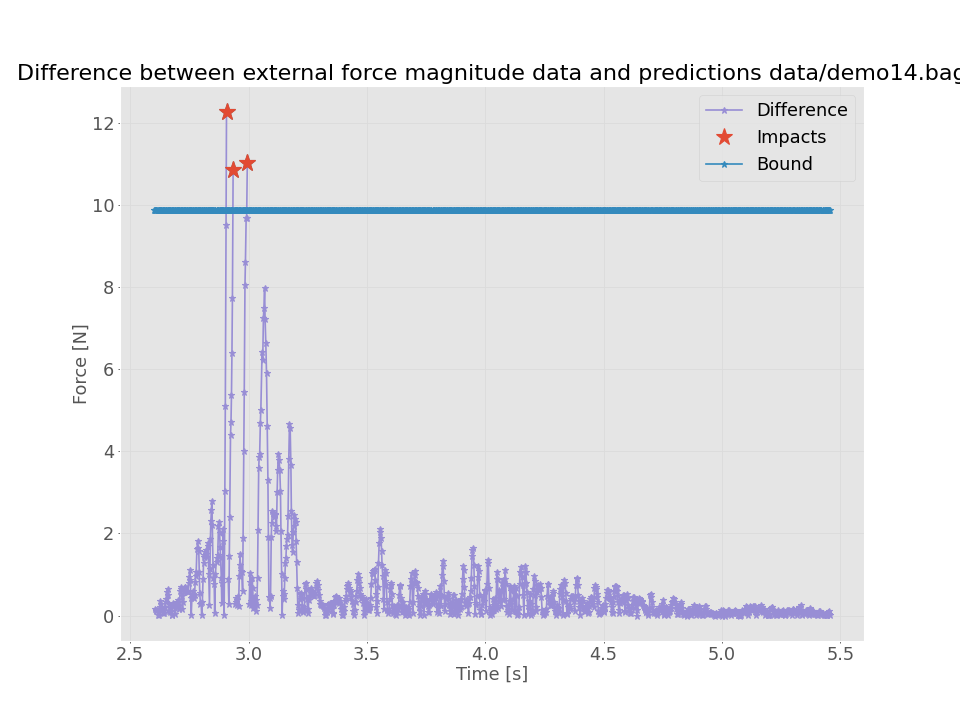

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


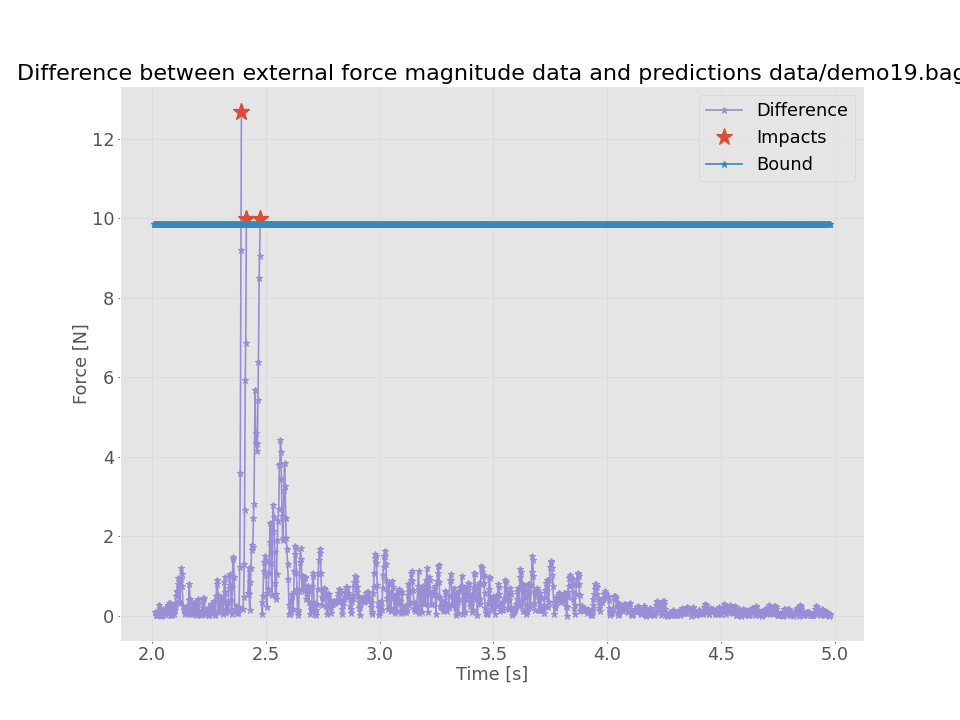

In [17]:
# Plot difference between data and prediction

for i in indices3:
    demo = config.demos[i]
    starting_index = starting_indices[i]
    ending_index = ending_indices[i]
    pred_diff = abs(force_ext[i][starting_index:ending_index] - predictions_data[i])
    
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Difference between data and prediction
    plt.plot(pred_diff.time, pred_diff.value, 'C2-*', linewidth=config.linewidth, markersize=config.markersize2, label='Difference')
    pred_diff_jumps = pred_diff[[index - starting_index for index in jump_indices_data[i]]]
    plt.plot(pred_diff_jumps.time, pred_diff_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1)
    pred_diff_impacts = pred_diff[[index - starting_index for index in impact_indices_data[i]]]
    plt.plot(pred_diff_jumps.time, pred_diff_jumps.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1,label='Impacts')

    # Bound
    plt.plot(bounds_data[i].time, bounds_data[i].value, 'C1-*', linewidth=config.linewidth, markersize=config.markersize2, label='Bound')
    
    # Adding title and labels
    plt.title('Difference between external force magnitude data and predictions ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Force [N]',fontsize=config.fontsize2)
    plt.legend(fontsize=config.fontsize2)
    if config.xlim is not None and config.xlim[i] is not None:
        plt.xlim(config.xlim[i])

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()
        
if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


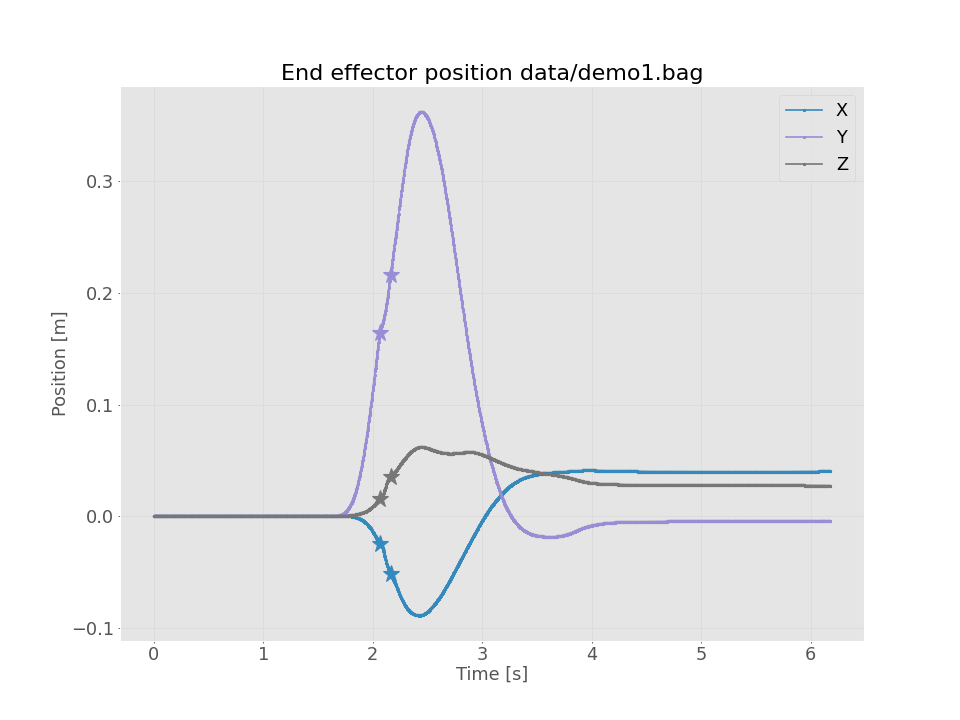

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


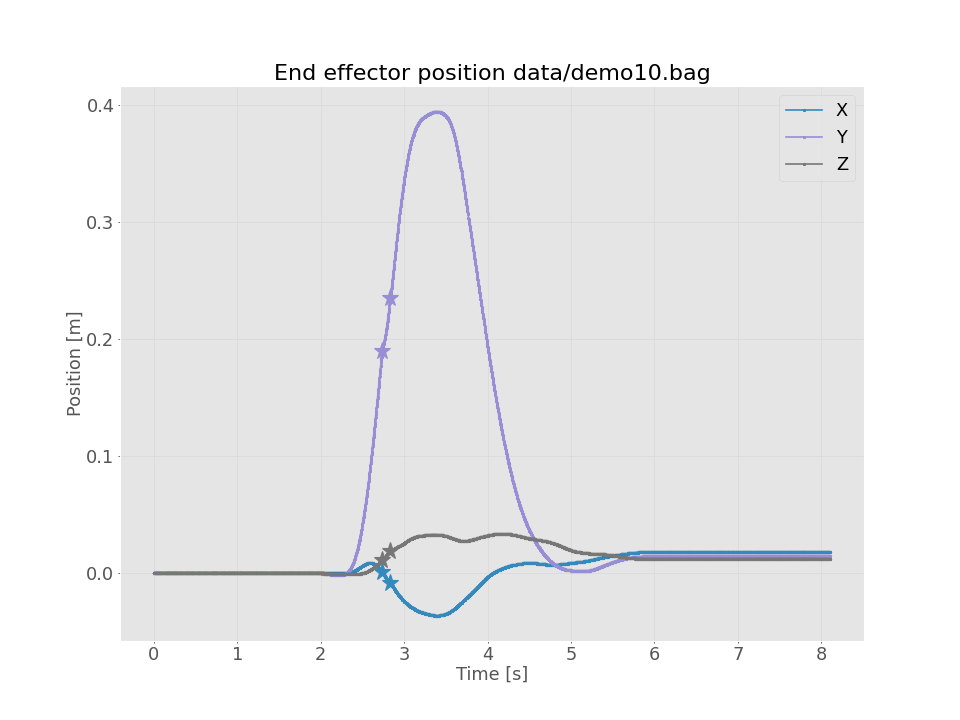

<IPython.core.display.Javascript object>


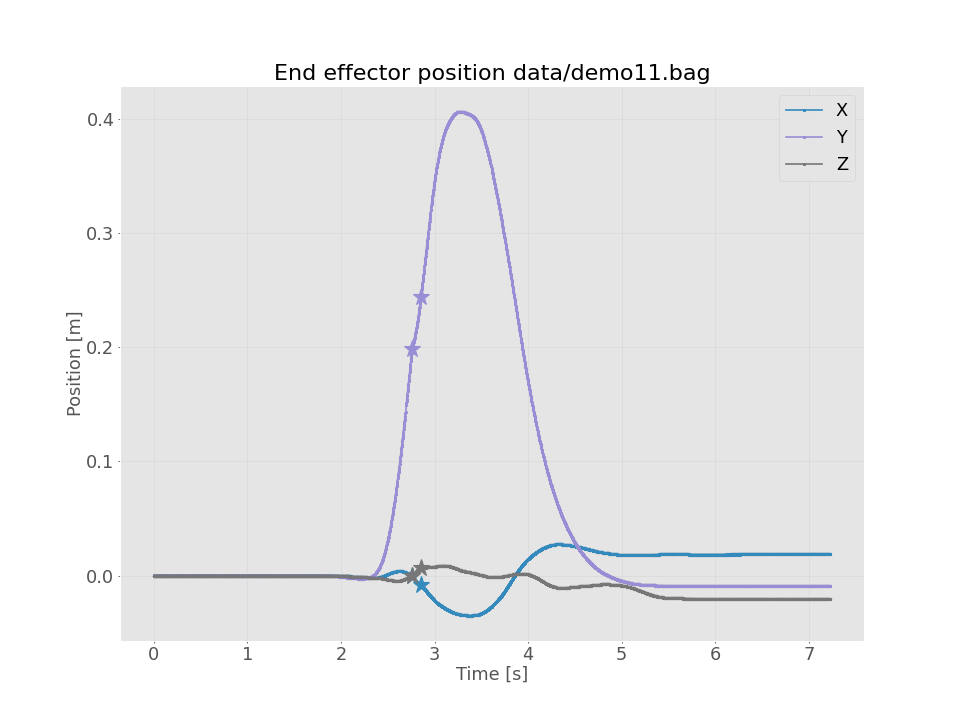

<IPython.core.display.Javascript object>


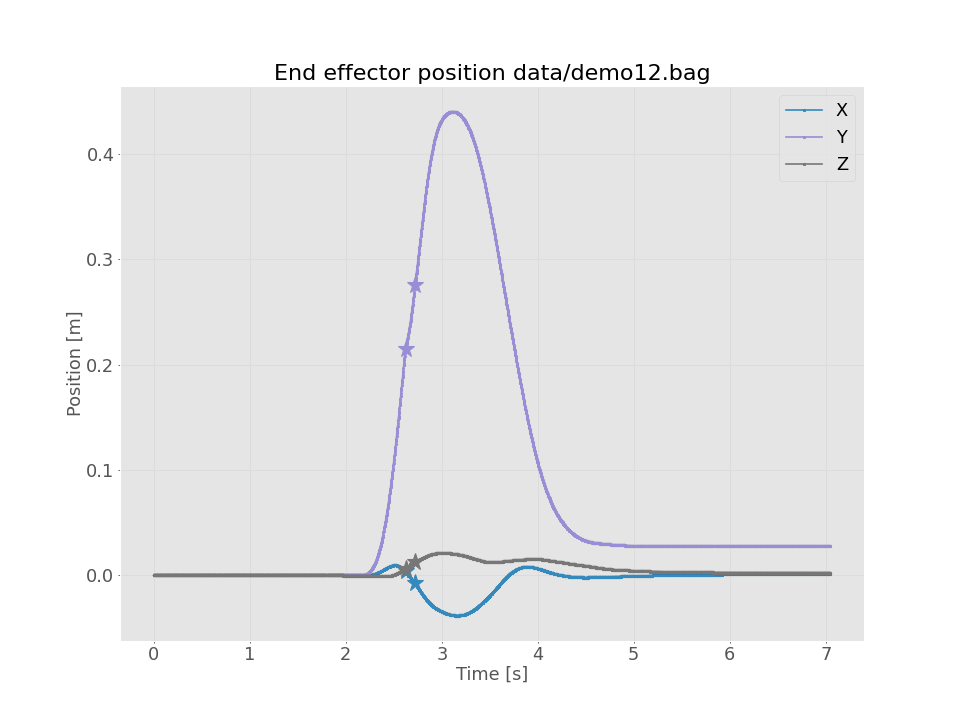

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


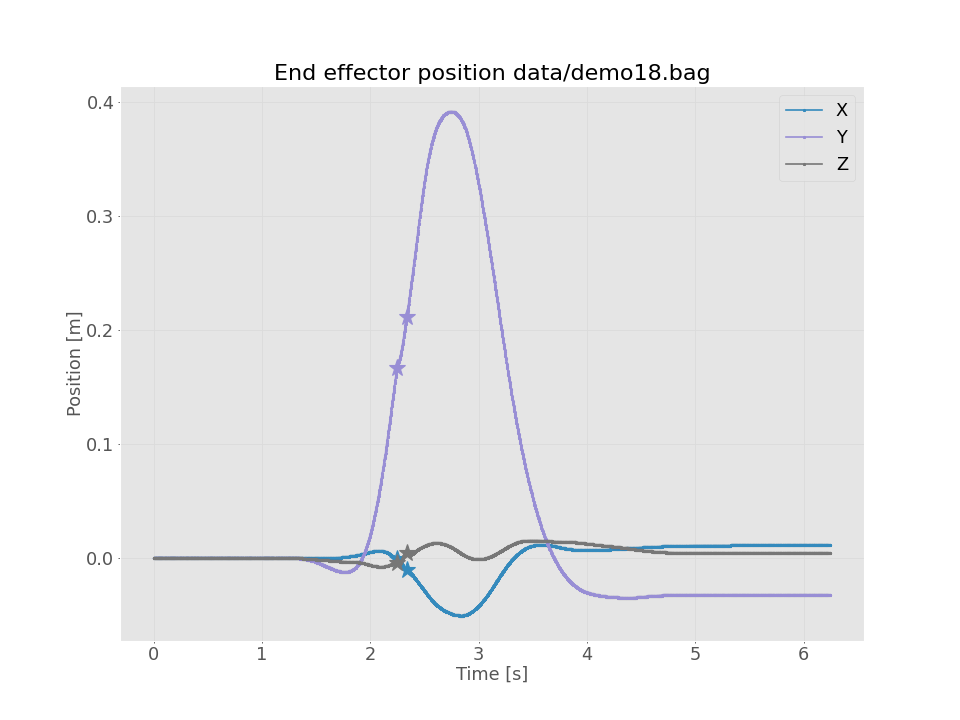

<IPython.core.display.Javascript object>

In [18]:
# Plot position data

for i in indices3:
    
    demo = config.demos[i]

    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Position
    for j in range(3):
        plt.plot(position_data[i].time, (position_data[i].get_index(j)-position_data[i].get_index(j)[0]).value, 'C' + str(j+1) + '-*', linewidth=config.linewidth, markersize=config.markersize3, label=config.labels[j])
        position_jumps = position_data[i].get_index(j)[impact_indices_data[i]]
        plt.plot(position_jumps.time, (position_jumps-position_data[i].get_index(j)[0]).value, 'C' + str(j+1) + '*', linewidth=config.linewidth, markersize=config.markersize1)

    # Adding title and labels
    plt.title('End effector position ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Position [m]',fontsize=config.fontsize2)
    plt.legend(fontsize=config.fontsize2)
    if config.xlim is not None and config.xlim[i] is not None:
        plt.xlim(config.xlim[i])

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()
        
if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


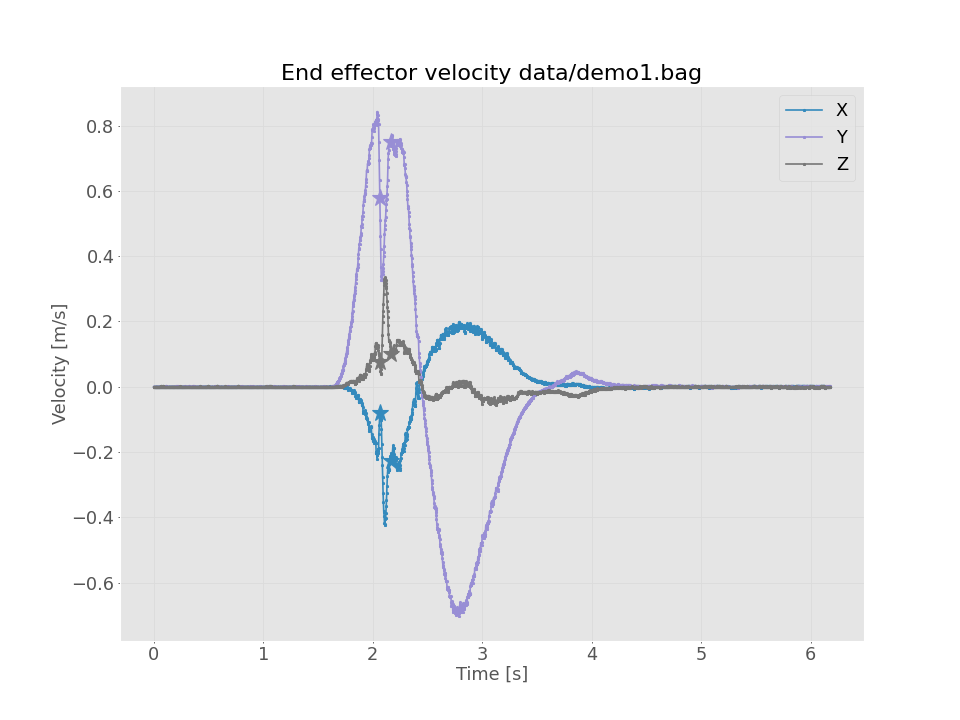

<IPython.core.display.Javascript object>


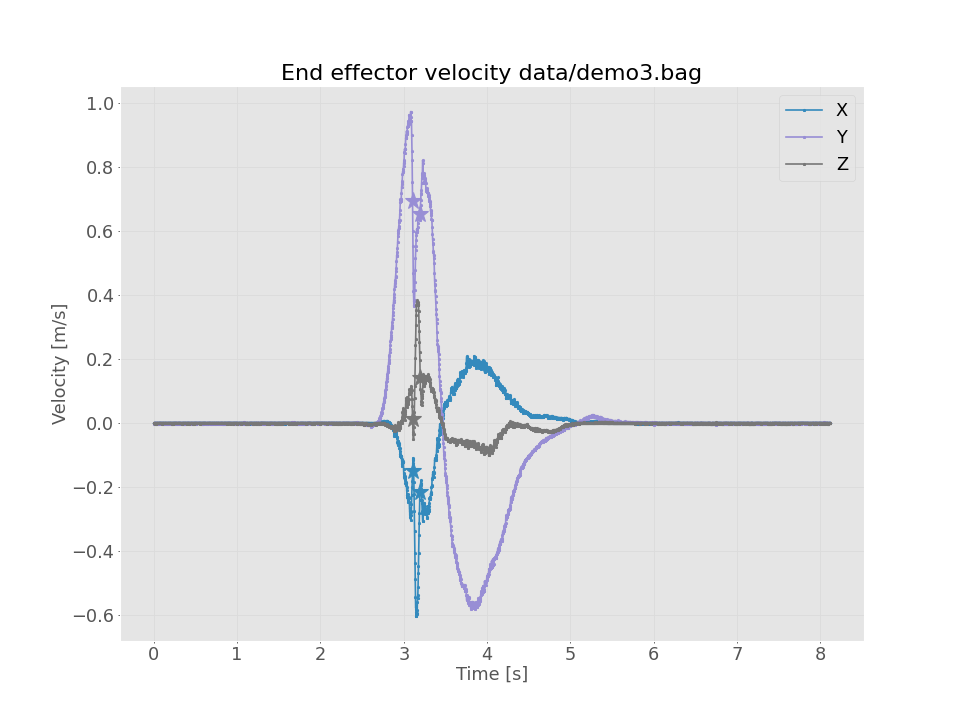

<IPython.core.display.Javascript object>


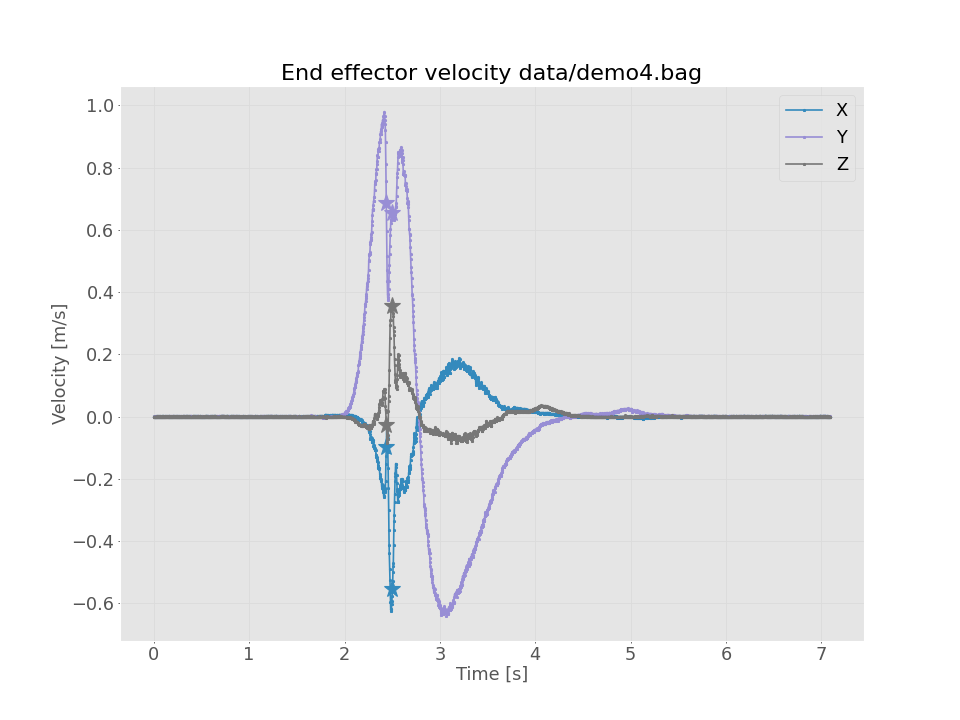

<IPython.core.display.Javascript object>


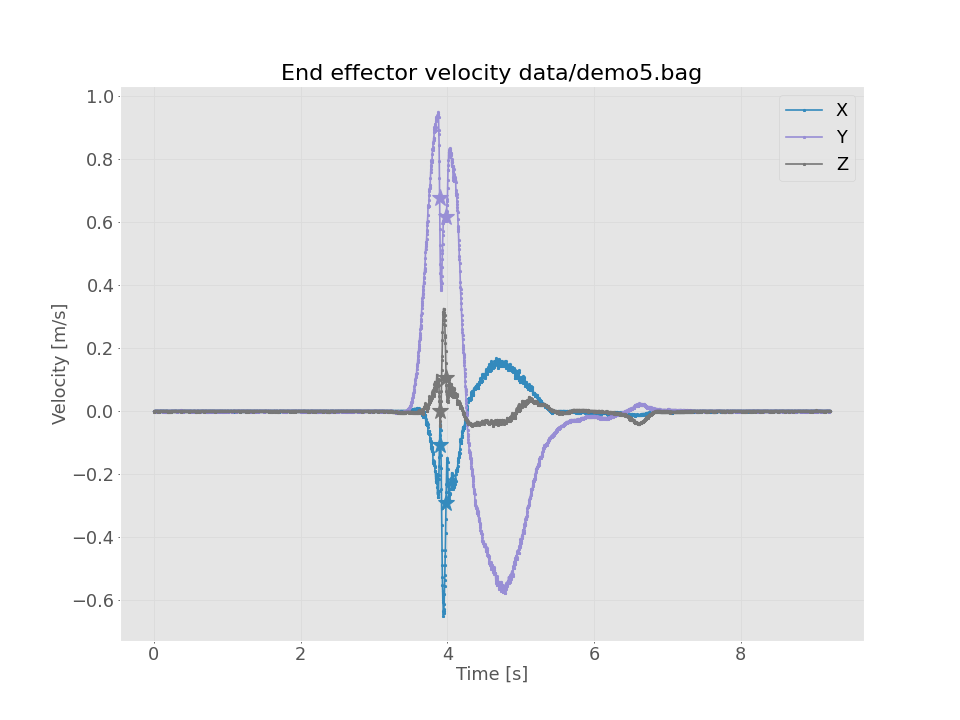

<IPython.core.display.Javascript object>


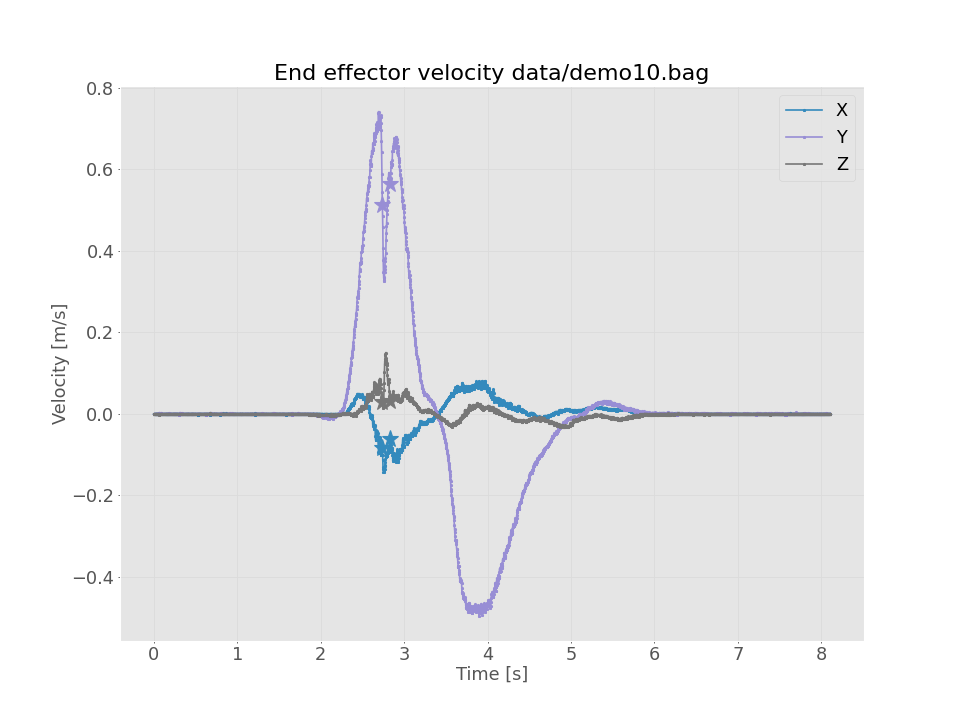

<IPython.core.display.Javascript object>


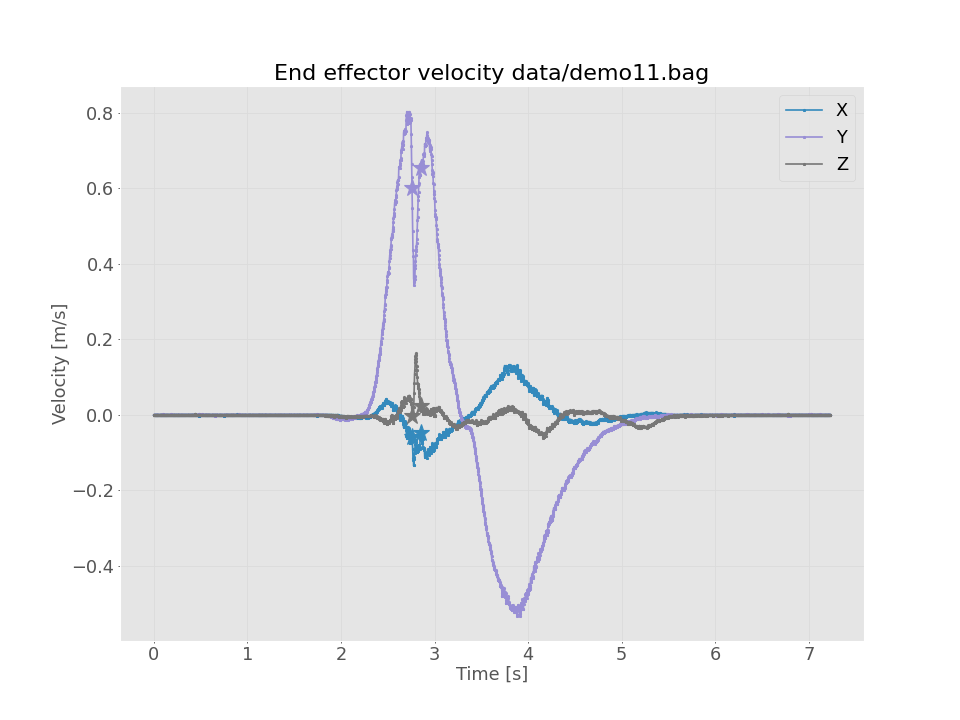

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


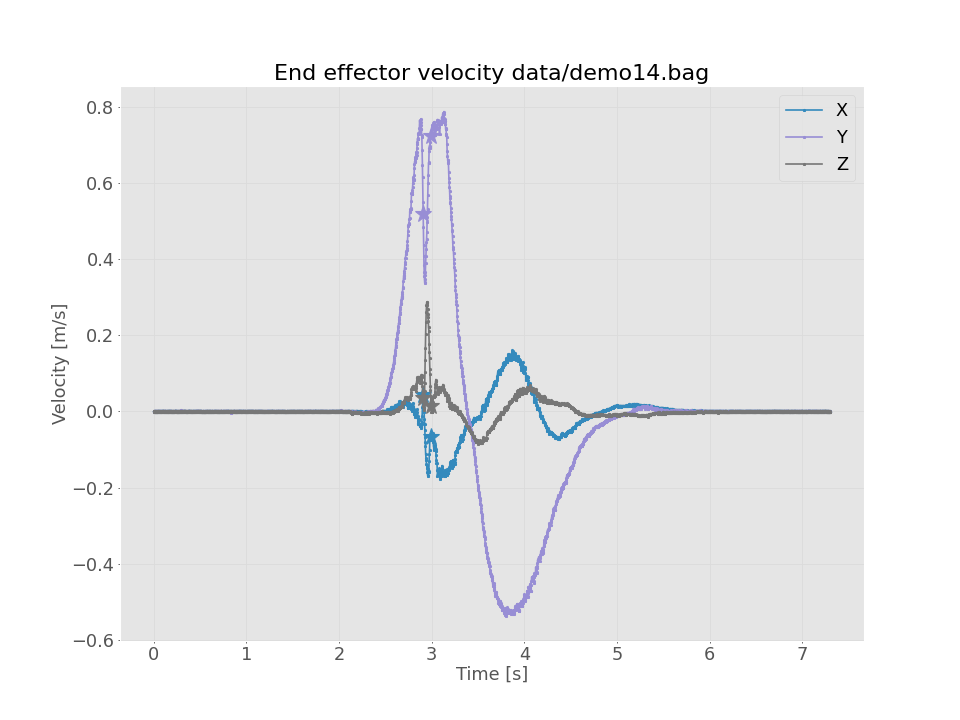

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


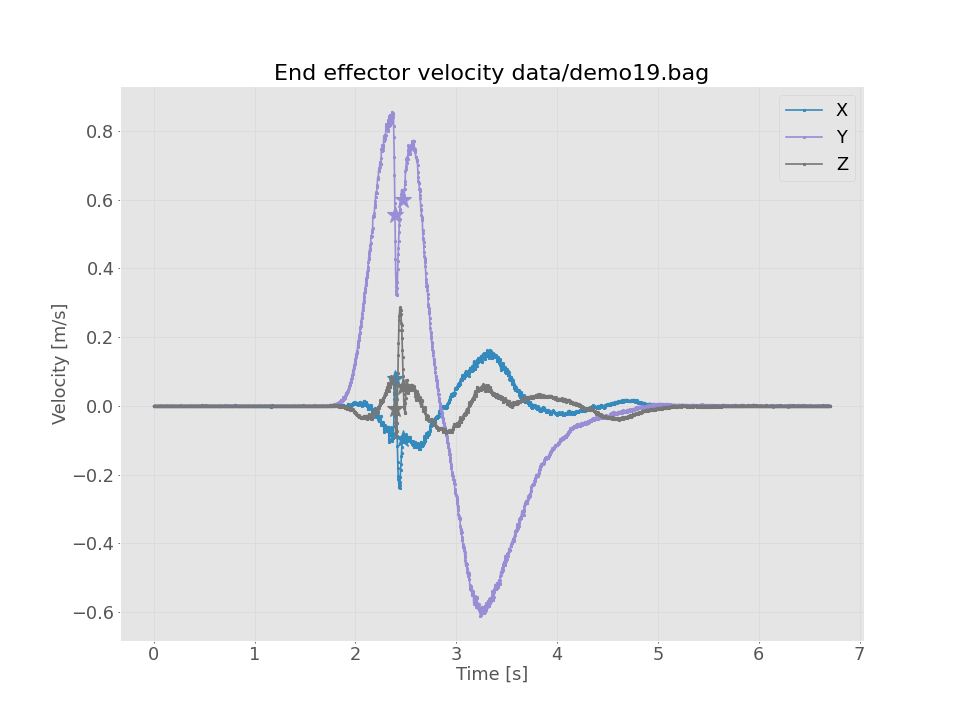

In [19]:
# Plot velocity data

for i in indices3:
    
    demo = config.demos[i]
    
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Velocity
    for j in range(3):
        plt.plot(velocity_data[i].time, velocity_data[i].get_index(j).value, 'C' + str(j+1) + '-*', linewidth=config.linewidth, markersize=config.markersize3, label=config.labels[j])
        velocity_jumps = velocity_data[i].get_index(j)[impact_indices_data[i]]
        plt.plot(velocity_jumps.time, velocity_jumps.value, 'C' + str(j+1) + '*', linewidth=config.linewidth, markersize=config.markersize1)

    # Adding title and labels
    plt.title('End effector velocity ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Velocity [m/s]',fontsize=config.fontsize2)
    plt.legend(fontsize=config.fontsize2)
    if config.xlim is not None and config.xlim[i] is not None:
        plt.xlim(config.xlim[i])

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()
        
if config.show_figs:
    plt.show()

In [ ]:
print("--- Entire script took %s seconds ---" % (t.time() - script_starting_time))